<a href="https://colab.research.google.com/github/azizamirsaidova/lab4_training/blob/main/scaffold_Lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training Recommendation systems and interpreting the results

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


%matplotlib inline

## Read in the data and prepare it

In [3]:
df = pd.read_csv("ratings.csv")
df.head() #grouped by userID

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [4]:
df.shape

(100836, 4)

In [5]:
moviesdf = pd.read_csv("movies.csv")
moviesdf.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


To use embeddings, we must set up the index to be consecutive.

In [24]:
users = df.userId.unique()
movies = df.movieId.unique()#df!!!.moviedId -  only rated movie ID
#users,movies #1 to 610, 1 to 163981
#df[df['rating']==1].shape

(2811, 4)

In [25]:
moviesdf[moviesdf.movieId==2]

,movieId,title,genres,id
1,2,Jumanji (1995),Adventure|Children|Fantasy,481


In [8]:
movieid2idx = {o:i for i,o in enumerate(movies)}

In [26]:
userid2idx = {o:i for i,o in enumerate(users)} #all the users 0 indexed
movieid2idx = {o:i for i,o in enumerate(movies)}#mapping rated movieIDs to 0 indexed
#userid2idx

In [ ]:
#movieid2idx

In [29]:
df['movieId'] = df.movieId.apply(lambda x: movieid2idx[x])
df['userId'] = df.userId.apply(lambda x: userid2idx[x])


moviesdf = moviesdf[moviesdf.movieId.isin(movies)] #getting all the movie info for the movies that are rated
moviesdf['id'] = moviesdf.movieId.apply(lambda x: movieid2idx[x]) #making a new column called ID which has the new final df movie ID 
moviesdf.head()

,movieId,title,genres,id
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1
1,2,Jumanji (1995),Adventure|Children|Fantasy,2
2,3,Grumpier Old Men (1995),Comedy|Romance,3
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,4
4,5,Father of the Bride Part II (1995),Comedy,5


You could also do this using up a categorical dtype

df.userId = df.userId.astype('category').cat.codes.values
df.movieId = df.movieId.astype('category').cat.codes.values

In [30]:
moviesdf = moviesdf.drop('movieId', axis=1).set_index('id')
moviesdf.head() #completed the transformation

,title,genres
id,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama|Romance
5,Father of the Bride Part II (1995),Comedy


In [31]:
df.head()

,userId,movieId,rating,timestamp
0,0,0,4.0,964982703
1,0,1,4.0,964981247
2,0,2,4.0,964982224
3,0,3,5.0,964983815
4,0,4,5.0,964982931


In [32]:
movie_names = moviesdf.title.to_dict() #trasnformed key:movie name

In [35]:
df.to_csv("ratings_contig.csv", index=False)
moviesdf.to_csv("movies_contig.csv", index=False)

In [36]:
nusers = df.userId.nunique()
nmovies = df.movieId.nunique()
nusers, nmovies

(610, 9724)

## Setting up the Model

### Train-test split

In [37]:
np.random.seed=2017
from sklearn.model_selection import train_test_split
train_indices, val_indices = train_test_split(range(df.shape[0]), train_size=0.8)
trdf = df.iloc[train_indices]
valdf = df.iloc[val_indices]
trdf.shape, valdf.shape

((80668, 4), (20168, 4))

In [38]:
import tensorflow.keras as keras
import tensorflow as tf
print(tf.__version__)

2.4.1


In [39]:
from tensorflow.keras.layers import Input, Embedding, Add, Dot, Flatten
from tensorflow.keras import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

We first set our hypeparameters, the size of the latent factors or the embeddings, up, and the amount of regularization. You will usually want to fit these hyper-parameters on the validation set.

In [40]:
L = 50

In [41]:
REG=5e-4

We first write a function to return us a bias layer:

In [42]:
def create_bias(name, inp, n_in, reg):
    #x = Embedding(n_in, 1, input_length=1, embeddings_regularizer=l2(reg))(inp)
    x = Embedding(n_in, 1, input_length=1, name=name)(inp)
    return Flatten(name=name+'_flat')(x)

and then another one to set us up an embedding layer...

In [43]:
def embedding_input(name, n_in, n_out, reg):
    inp = Input(shape=(1,), dtype='int64', name=name)
    return inp, Embedding(n_in, n_out, input_length=1, name=name.split('_')[0]+'_factor', embeddings_regularizer=l2(reg))(inp)

This function also returns input layers which we will use as placeholders for our inputs, which are the userids and movieids which are used as indexes into the embedding to get the latent factors for a particular user or movie.

Now we define our embeddings and biases...

In [109]:
user_input, uLmat = embedding_input('user_input', nusers, L, REG)
movie_input, mLmat = embedding_input('movie_input', nmovies, L, REG)

The user input is a placeholder for userids and ditto for the movie inputs...

In [45]:
user_input.shape, movie_input.shape

(TensorShape([None, 1]), TensorShape([None, 1]))

In [46]:
uLmat.shape, mLmat.shape

(TensorShape([None, 1, 50]), TensorShape([None, 1, 50]))

In [47]:
user_bias = create_bias('user_bias', user_input, nusers, REG)
movie_bias = create_bias('movie_bias', movie_input, nmovies, REG)

In [48]:
user_bias.shape, movie_bias.shape

(TensorShape([None, 1]), TensorShape([None, 1]))

The embeddings are matrix multiplied together (dot producted together) to get the residual matrix, which is then flattened.

In [50]:
residual = Dot(axes=2, name="residual")([uLmat, mLmat])

In [51]:
residual.shape

TensorShape([None, 1, 1])

In [52]:
residflat = Flatten(name="residual_flat")(residual)
residflat.shape

TensorShape([None, 1])

We add the flattened residual and the biases into the linear regression..

In [53]:
regression = Add(name="regression")([user_bias, movie_bias, residflat]) #why?

In [54]:
regression.shape

TensorShape([None, 1])

..and then put a custom sigmoid activation to limit things between 0 and 5.5..we dont want our linear regression to go all over the place...

In [55]:
from tensorflow.keras.layers import Activation
from tensorflow.keras import backend as K

In [56]:
def sigmoid_maker(low, high):
    def custom_sigmoid(x):
        return K.sigmoid(x)*(high - low) + low #within range
    return custom_sigmoid

In [57]:
cs = sigmoid_maker(0, 5.5)

In [58]:
output = Activation(cs, name="Sigmoid_Range")(regression)

Now we set up the model with the userids and movieds as input, and the output of the sigmoid as output..and ask Keras for a summary..compiling it with Adam and a learning rate of 0.001.

In [59]:
model = Model([user_input, movie_input], output)
model.compile(Adam(0.001), loss='mse')

In [60]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
movie_input (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_factor (Embedding)         (None, 1, 50)        30500       user_input[0][0]                 
__________________________________________________________________________________________________
movie_factor (Embedding)        (None, 1, 50)        486200      movie_input[0][0]                
______________________________________________________________________________________________

In [61]:
import pydot

In [62]:
from tensorflow.keras.utils import model_to_dot

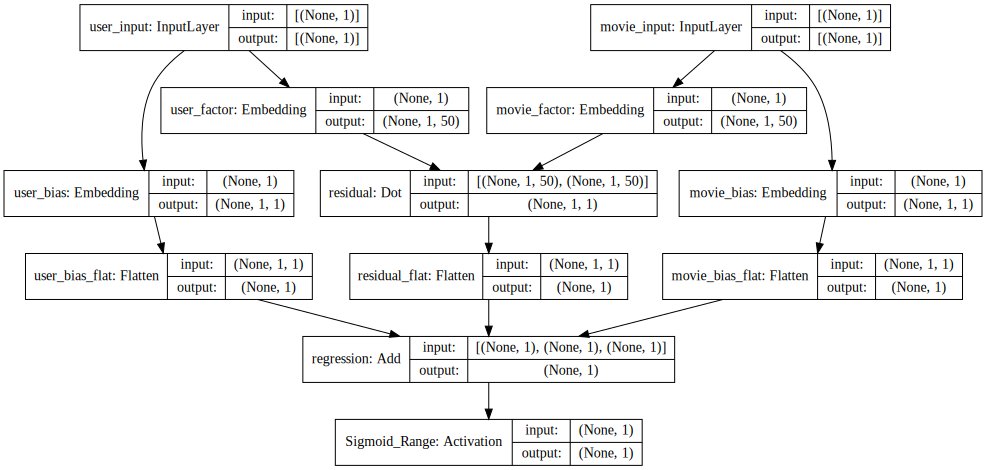

In [63]:
from IPython.display import SVG
SVG(model_to_dot(model,  show_shapes=True, show_layer_names=True, dpi=72, rankdir='TB').create_svg())

## Training the model

We start slow with a learning rate of 0.001, then speed up to 0.01 and then slow back down so that we dont overshoot into having our validation loss climb back up..because then we would be overfitting...

In [64]:
#your code here
histdict={}
lr=[0.001,0.01, 0.002]

In [97]:
#your code here
model.optimizer.lr = lr[0]
histdict[0] = model.fit([trdf.userId,trdf.movieId],trdf.rating, epochs=4, batch_size=30, validation_data=([valdf.userId, valdf.movieId], valdf.rating))


Epoch 1/4
2689/2689 [==============================] - 18s 7ms/step - loss: 0.6180 - val_loss: 0.7802
Epoch 2/4
2689/2689 [==============================] - 17s 6ms/step - loss: 0.6176 - val_loss: 0.7801
Epoch 3/4
2689/2689 [==============================] - 17s 6ms/step - loss: 0.6170 - val_loss: 0.7795
Epoch 4/4
2689/2689 [==============================] - 17s 6ms/step - loss: 0.6167 - val_loss: 0.7793


In [98]:
#your code here
model.optimizer.lr = lr[1]
histdict[1] = model.fit([trdf.userId,trdf.movieId],trdf.rating, epochs=4, batch_size=30, validation_data=([valdf.userId, valdf.movieId], valdf.rating))



Epoch 1/4
2689/2689 [==============================] - 17s 6ms/step - loss: 0.9274 - val_loss: 0.9602
Epoch 2/4
2689/2689 [==============================] - 17s 6ms/step - loss: 0.8748 - val_loss: 0.9705
Epoch 3/4
2689/2689 [==============================] - 17s 6ms/step - loss: 0.8584 - val_loss: 0.9805
Epoch 4/4
2689/2689 [==============================] - 17s 6ms/step - loss: 0.8654 - val_loss: 0.9743


In [99]:
#your code here
model.optimizer.lr = lr[2]
histdict[2] = model.fit([trdf.userId,trdf.movieId],trdf.rating, epochs=4, batch_size=30, validation_data=([valdf.userId, valdf.movieId], valdf.rating))




Epoch 1/4
2689/2689 [==============================] - 17s 6ms/step - loss: 0.6530 - val_loss: 0.7885
Epoch 2/4
2689/2689 [==============================] - 17s 6ms/step - loss: 0.6313 - val_loss: 0.7939
Epoch 3/4
2689/2689 [==============================] - 17s 6ms/step - loss: 0.6320 - val_loss: 0.7904
Epoch 4/4
2689/2689 [==============================] - 17s 6ms/step - loss: 0.6313 - val_loss: 0.7903


### Plot the trajectory of the validation loss

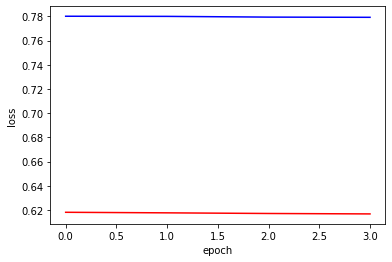

In [104]:
#your code here
plt.ylabel('loss')
plt.xlabel('epoch')

plt.plot(histdict[0].history['loss'], color='red')
plt.plot(histdict[0].history['val_loss'], color='blue')


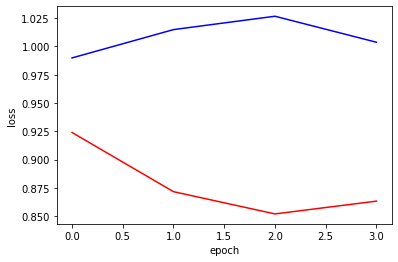

In [105]:
#your code here
plt.ylabel('loss')
plt.xlabel('epoch')

plt.plot(histdict[1].history['loss'], color='red')
plt.plot(histdict[1].history['val_loss'], color='blue')


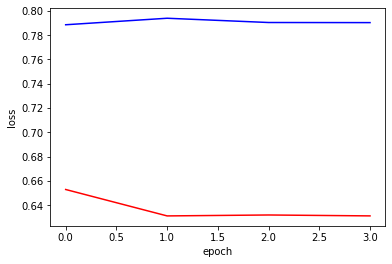

In [106]:
#your code here
plt.ylabel('loss')
plt.xlabel('epoch')

plt.plot(histdict[2].history['loss'], color = 'red')
plt.plot(histdict[2].history['val_loss'], color = 'blue')


## EarlyStopping

Implement earlystopping to observe the point at which your validation loss will start to climb

In [107]:
#Pick a learning rate and apply EarlyStopping
#your code here
es = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1)

model.optimizer.lr = lr[1]
histdict[1] = model.fit([trdf.userId,trdf.movieId],trdf.rating, epochs=4, batch_size=30, validation_data=([valdf.userId, valdf.movieId], valdf.rating), callbacks = [es])




Epoch 1/4
2689/2689 [==============================] - 17s 6ms/step - loss: 0.8698 - val_loss: 0.9876
Epoch 2/4
2689/2689 [==============================] - 18s 7ms/step - loss: 0.8601 - val_loss: 0.9605
Epoch 3/4
2689/2689 [==============================] - 18s 7ms/step - loss: 0.8636 - val_loss: 0.9999
Epoch 00003: early stopping


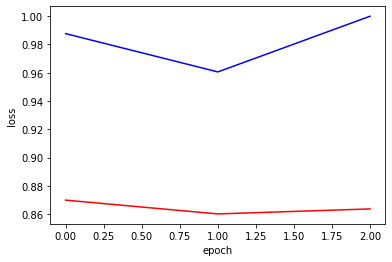

In [108]:
#your code here
plt.ylabel('loss')
plt.xlabel('epoch')

plt.plot(histdict[1].history['loss'], color='red')
plt.plot(histdict[1].history['val_loss'], color='blue')


## Choosing different L and Reg 

Create the same model for two different 'L' or output dimension of latent factors and also vary the regularization 'Reg'

In [118]:
#your code here
L=50
REG = 5e-4
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import GridSearchCV

param_grid = {'L': [25, 100], 'REG': [5e-4, 5e-8]}

#grid = GridSearchCV(,param_grid)

In [117]:
user_input, uLmat = embedding_input('user_input', nusers, L, REG)
movie_input, mLmat = embedding_input('movie_input', nmovies, L, REG)

In [ ]:
#Saving the model
model.save_weights("/content/drive/MyDrive/DS-1 /Lab 4/cf.h5")